In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import pathlib
import datetime
import time


# Gender classification

## Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_folder = '/content/drive/MyDrive/ce4042'
training_path = os.path.join(base_folder, "classified_images.zip")

!unzip -q $training_path

data_root = tf.keras.utils.get_file(
  'classified_images',
  'https://drive.google.com/drive/folders/1y9xYx5uFkG8uZqLaqbDHMB92AO-ZG9fU?usp=sharing',
   extract = True)

import pathlib
data_dir = pathlib.Path('/content/classified_images') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

12676

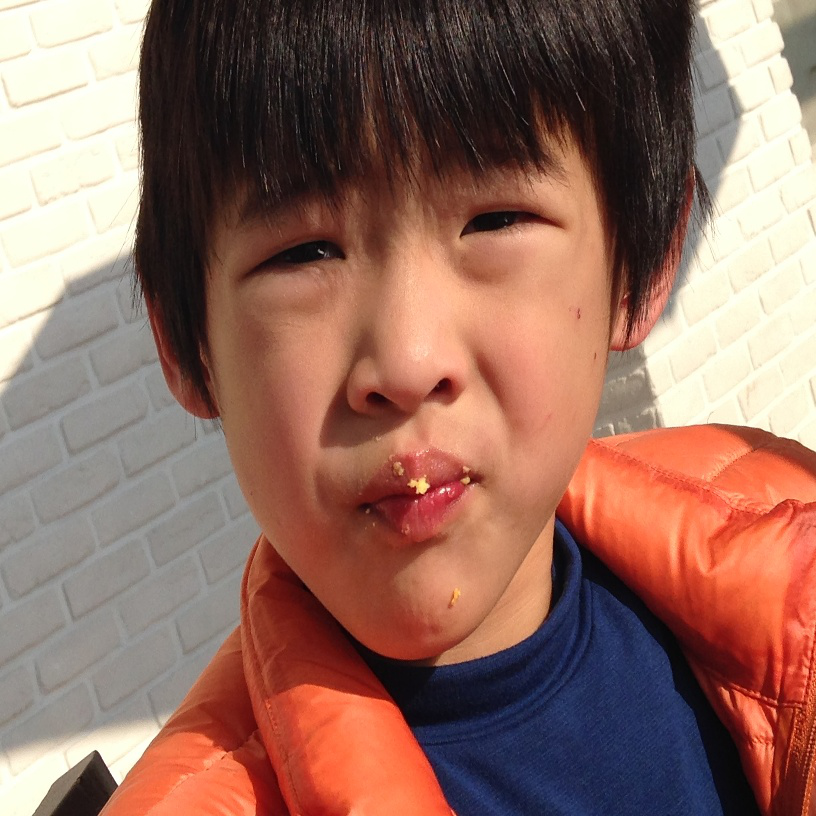

In [ ]:
male_face = list(data_dir.glob('male_face/*'))
PIL.Image.open(str(male_face[0]))

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

# Spliting dataset to train and test 0.9 to 0.1
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12676 files belonging to 2 classes.
Using 11409 files for training.
Found 12676 files belonging to 2 classes.
Using 1267 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['female_face', 'male_face']


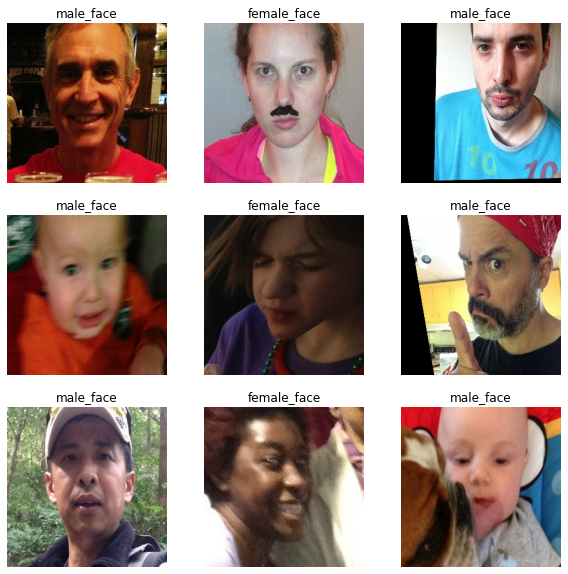

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


#Data Augmentation
##Apply the preprocessing layers to your dataset

In [ ]:
# data augmentation flip and rotation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2)  
])

In [ ]:
batch_size = 32

def prepare(ds, augment=False):
  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)

# Building model

In [ ]:
num_classes = 2

#basic model
model = Sequential([
  layers.Conv2D(16, 3, input_shape=(img_width,img_height,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 32, 32, 64)     

In [ ]:
#Defining early stopping
def early_stop_callback(name):
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

In [ ]:
#Callback to restore best model weights 
checkpoint_filepath = './best_weights_file'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
NUM_EPOCHS = 100

history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=32,
                    epochs=NUM_EPOCHS,
                    callbacks = [early_stop_callback("early"), model_checkpoint_callback])

Epoch 1/100
357/357 [==============================] - 30s 81ms/step - loss: 0.6557 - accuracy: 0.6230 - val_loss: 0.5809 - val_accuracy: 0.6811
Epoch 2/100
357/357 [==============================] - 28s 77ms/step - loss: 0.5942 - accuracy: 0.6806 - val_loss: 0.5964 - val_accuracy: 0.6835
Epoch 3/100
357/357 [==============================] - 29s 81ms/step - loss: 0.5756 - accuracy: 0.7009 - val_loss: 0.5441 - val_accuracy: 0.7143
Epoch 4/100
357/357 [==============================] - 28s 77ms/step - loss: 0.5554 - accuracy: 0.7153 - val_loss: 0.5558 - val_accuracy: 0.7159
Epoch 5/100
357/357 [==============================] - 29s 80ms/step - loss: 0.5445 - accuracy: 0.7215 - val_loss: 0.5194 - val_accuracy: 0.7356
Epoch 6/100
357/357 [==============================] - 28s 77ms/step - loss: 0.5228 - accuracy: 0.7407 - val_loss: 0.5214 - val_accuracy: 0.7435
Epoch 7/100
357/357 [==============================] - 29s 81ms/step - loss: 0.5136 - accuracy: 0.7421 - val_loss: 0.4646 - val_ac

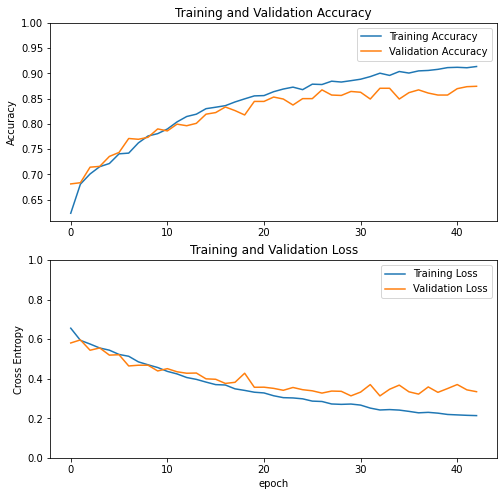

In [ ]:
# plot graph for basic model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# performance of basic model
lowest_val_loss = min(history.history['val_loss'])
lowest_loss_index = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][lowest_loss_index]
print("lowest val loss = ", lowest_val_loss)
print("val accuracy = ", val_acc)


lowest val loss =  0.31316083669662476
val accuracy =  0.8705604076385498


## Optimizing the model

### 1. adding more layers

In [ ]:
# addinging 2 more layers from basic model
model_more_2layers = Sequential([
  layers.Conv2D(16, 3, input_shape=(img_width,img_height,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model_more_2layers.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_more_2layers.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 32, 32, 64)     

In [ ]:
NUM_EPOCHS = 100

history = model_more_2layers.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=32,
                    epochs=NUM_EPOCHS,
                    callbacks = [early_stop_callback("early2"), model_checkpoint_callback])

Epoch 1/100
357/357 [==============================] - 28s 78ms/step - loss: 0.5294 - accuracy: 0.7345 - val_loss: 0.4865 - val_accuracy: 0.7711
Epoch 2/100
357/357 [==============================] - 28s 78ms/step - loss: 0.5054 - accuracy: 0.7498 - val_loss: 0.4639 - val_accuracy: 0.7853
Epoch 3/100
357/357 [==============================] - 28s 78ms/step - loss: 0.4834 - accuracy: 0.7635 - val_loss: 0.4571 - val_accuracy: 0.7782
Epoch 4/100
357/357 [==============================] - 28s 78ms/step - loss: 0.4658 - accuracy: 0.7800 - val_loss: 0.4430 - val_accuracy: 0.7861
Epoch 5/100
357/357 [==============================] - 28s 78ms/step - loss: 0.4509 - accuracy: 0.7860 - val_loss: 0.4291 - val_accuracy: 0.7995
Epoch 6/100
357/357 [==============================] - 28s 78ms/step - loss: 0.4285 - accuracy: 0.7966 - val_loss: 0.4204 - val_accuracy: 0.8129
Epoch 7/100
357/357 [==============================] - 28s 78ms/step - loss: 0.4060 - accuracy: 0.8144 - val_loss: 0.4028 - val_ac

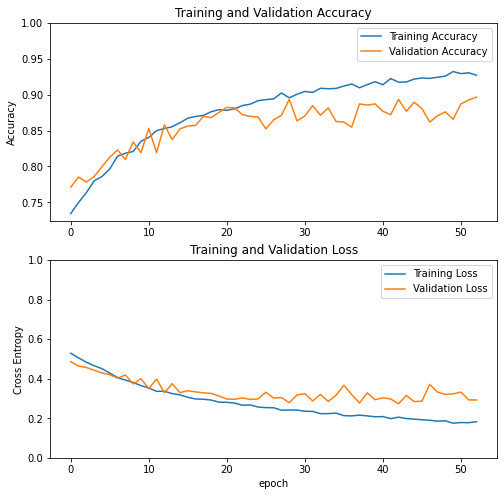

In [ ]:
# plotting performance for additional 2 layers model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# performance of model with additional 2 layers
lowest_val_loss = min(history.history['val_loss'])
lowest_loss_index = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][lowest_loss_index]
print("lowest val loss = ", lowest_val_loss)
print("val accuracy = ", val_acc)

lowest val loss =  0.27350518107414246
val accuracy =  0.893449068069458


In [ ]:
num_classes = 2

#addinging 4 more layers from basic model
model_more_4layers = Sequential([
  layers.Conv2D(16, 3, input_shape=(img_width,img_height,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model_more_4layers.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_more_4layers.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)      

In [ ]:
NUM_EPOCHS = 200

history = model_more_4layers.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=32,
                    epochs=NUM_EPOCHS,
                    callbacks = [early_stop_callback("early3"), model_checkpoint_callback])

Epoch 1/200
357/357 [==============================] - 56s 108ms/step - loss: 0.6633 - accuracy: 0.5948 - val_loss: 0.6901 - val_accuracy: 0.5391
Epoch 2/200
357/357 [==============================] - 36s 100ms/step - loss: 0.6302 - accuracy: 0.6448 - val_loss: 0.6151 - val_accuracy: 0.6535
Epoch 3/200
357/357 [==============================] - 36s 101ms/step - loss: 0.6014 - accuracy: 0.6758 - val_loss: 0.5584 - val_accuracy: 0.7238
Epoch 4/200
357/357 [==============================] - 36s 101ms/step - loss: 0.5786 - accuracy: 0.6947 - val_loss: 0.5432 - val_accuracy: 0.7206
Epoch 5/200
357/357 [==============================] - 35s 96ms/step - loss: 0.5554 - accuracy: 0.7142 - val_loss: 0.5628 - val_accuracy: 0.7017
Epoch 6/200
357/357 [==============================] - 36s 100ms/step - loss: 0.5332 - accuracy: 0.7324 - val_loss: 0.4722 - val_accuracy: 0.7672
Epoch 7/200
357/357 [==============================] - 34s 95ms/step - loss: 0.5077 - accuracy: 0.7523 - val_loss: 0.4734 - v

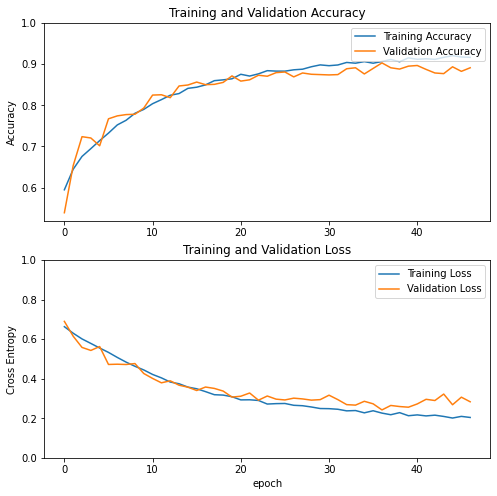

In [ ]:
# plotting performance for model with additional 4 layers from basic model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# performance of model with additional 4 layers from basic model
lowest_val_loss = min(history.history['val_loss'])
lowest_loss_index = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][lowest_loss_index]
print("lowest val loss = ", lowest_val_loss)
print("val accuracy = ", val_acc)

lowest val loss =  0.24226084351539612
val accuracy =  0.9029203057289124


## Prediction

In [ ]:
# predicting the val_ds
predicted_batch = model_more_4layers.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_id
predicted_label_batch=[]
for i in predicted_id.numpy():
    if(i==1):
        predicted_label_batch.append("male")
    else:
        predicted_label_batch.append("female")
print(predicted_label_batch)

['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'female', 'female', 'female', 'male', 'female', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'female', 'female']


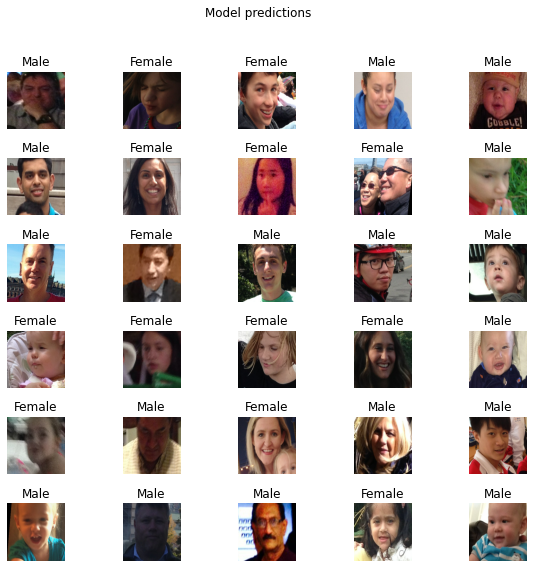

In [ ]:
# plotting the predicted images
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")